In [1]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import seaborn as sns
from scipy.stats import pearsonr
from collections import defaultdict
from tqdm import tqdm
import cv2
mpl.rcParams['font.family'] = 'Apple SD Gothic Neo'

/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


## matplotlib 한글깨짐 현상
```python
ttfList = fm.fontManager.ttflist
fontlist = [font.name for font in ttfList]
fontlist.sort()
print(fontlist) # 사용가능한 font 리스트 출력
```
위 font 리스트에서 적당한 거 찾아서 
```python
mpl.rcParams['font.family'] = '<적당한거>'
```
로 적용하기

In [81]:
def month_year_iter(start_year, start_month, end_year, end_month):
    ym_start= 12*start_year + start_month - 1
    ym_end= 12*end_year + end_month - 1
    for ym in range(ym_start, ym_end):
        y, m = divmod( ym, 12 )
        yield y, m+1

# pd.date_range(start_date:str, end_date:str, freq='Y/M/D') 로 써도됨.
# pd.date_range(...).year , pd.date_range(...).month 메소드로 추출

BasePath = '/Users/yungi/Documents/pps_dataset'
DataList = []
for y, m in month_year_iter(2016, 11, 2021, 12):
    # CSV Preprocessing
    '''
    df1 = pd.read_csv(os.path.join(BasePath, '지역별지역업체실적비중_{}{:02d}.csv'.format(y, m)))
    df1 = df1.drop(columns=['CODE', 'DETAIL'])
    size = df1.shape[0]
    YM_df = pd.DataFrame({'YEAR':np.array([y]*size), 'MON':np.array([m]*size)})
    df1 = pd.concat([df1, YM_df], axis=1)
    '''
    # Excel Preprocessing
    df1 = pd.read_excel(os.path.join(BasePath, '지역별조달기업소재지_실적_{}{:02d}.xlsx'.format(y, m)), header=[0,1], index_col=0)
    df1.columns = pd.Series(['조달_'+''.join(col) for col in df1.columns])
    df1 = df1.drop(['전체', '국외소재', '미분류']).reset_index().rename(columns={'index':'소재지'})
    df1 = df1.drop(['조달_합계건수', '조달_합계금액'], axis=1)
    size = df1.shape[0]
    YM_df = pd.DataFrame({'YEAR':np.array([y]*size), 'MON':np.array([m]*size)})
    df1 = pd.concat([df1, YM_df], axis=1)

    df2 = pd.read_excel(os.path.join(BasePath, '지역별공공기관소재지_실적_{}{:02d}.xlsx'.format(y, m)), header=[0,1], index_col=0)
    df2.columns = pd.Index([''.join(multi_col) for multi_col in df2.columns])
    df2 = df2.drop('전체').reset_index().rename(columns={'index':'소재지'})
    df2 = df2.drop(['합계건수', '합계금액'], axis=1)

    # Merge with df1 and df2
    df1 = pd.merge(df1, df2, on='소재지', how='inner')
    DataList.append(df1)

dataset = pd.concat(DataList, axis=0, ignore_index=True)

/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [108]:
dataset.head()

소재지  조달_물품건수       조달_물품금액  조달_공사건수       조달_공사금액  조달_일반용역건수  \
0  서울특별시    38560  7.039213e+11     2352  351651036488       3604   
1  부산광역시     8065  1.517635e+11      950  160716720048        572   
2  대구광역시     6920  7.016842e+10      724  141337372622        552   
3  인천광역시     8216  1.142881e+11     1104  140104207586        678   
4  광주광역시     4307  4.827718e+10      527   63836658648        252   

      조달_일반용역금액  조달_기술용역건수    조달_기술용역금액  YEAR  MON   물품건수          물품금액  공사건수  \
0  2.324784e+11        787  85539066744  2016   11  20085  1.313200e+12  2489   
1  2.557079e+10        330   9383127261  2016   11  10009  1.261458e+11   896   
2  9.013915e+09        135   4779190152  2016   11   7604  8.586230e+10   732   
3  1.200580e+10        213   7551565603  2016   11   8296  1.058565e+11  1049   
4  8.901167e+09        100   1363640760  2016   11   4878  3.691101e+10   553   

           공사금액  일반용역건수        일반용역금액  기술용역건수        기술용역금액  
0  355926957451    2084  1.205402e+11     451  2.855435e+10  
1  154356452289     427  1.182560e+10     314  1.989309e+10  
2   92200100693     520  2.311276e+10     136  3.812820e+09  
3   71845773595     764  3.681854e+10     211  1.455825e+10  
4   61503221768     203  5.745290e+09      89  2.719696e+09

In [83]:
pr_dataset = pd.DataFrame(columns=['PR1', 'PR2', 'PR3', 'PR4'], index=dataset['소재지'].unique())
for i, loc in tqdm(enumerate(dataset['소재지'].unique())):
    target = dataset[dataset['소재지']==loc].reset_index(drop=True)
    # Pearson Correlation Coefficient -> (r, p-value) p-value 0.05 미만(일반적)일 때, 해당 상관계수 r값이 의미를 가진다.
    pr1 = pearsonr(target['물품금액'], target['조달_물품금액'])
    pr2 = pearsonr(target['공사금액'], target['조달_공사금액'])
    pr3 = pearsonr(target['일반용역금액'], target['조달_일반용역금액'])
    pr4 = pearsonr(target['기술용역금액'], target['조달_기술용역금액'])
    pr_dict = {'PR1':pr1[0], 'PR2':pr2[0], 'PR3':pr3[0], 'PR4':pr4[0]}
    pr_dataset.loc[loc] = pr_dict
    
    # Plot Scatter and Regression Line
    fig, axs = plt.subplots(1, 4, facecolor='w', figsize=(25,5))
    sns.regplot(x=target['물품금액'], y=target['조달_물품금액'], fit_reg=True, scatter_kws={"color": "black"}, line_kws={"color": "red"}, ax=axs[0])
    axs[0].set_title("Pearson r: {}, p-value: {}".format(round(pr1[0], 3), round(pr1[1], 5)), fontsize=15)
    axs[0].set_ylabel("조달_물품금액", fontsize=15)
    axs[0].set_xlabel("공공_물품금액", fontsize=15)
    sns.regplot(x=target['공사금액'], y=target['조달_공사금액'], fit_reg=True, scatter_kws={"color": "black"}, line_kws={"color": "red"}, ax=axs[1])
    axs[1].set_title("Pearson r: {}, p-value: {}".format(round(pr2[0], 3), round(pr2[1], 5)), fontsize=15)
    axs[1].set_ylabel("조달_공사금액", fontsize=15)
    axs[1].set_xlabel("공공_공사금액", fontsize=15)
    sns.regplot(x=target['일반용역금액'], y=target['조달_일반용역금액'], fit_reg=True, scatter_kws={"color": "black"}, line_kws={"color": "red"}, ax=axs[2])
    axs[2].set_title("Pearson r: {}, p-value: {}".format(round(pr3[0], 3), round(pr3[1], 5)), fontsize=15)
    axs[2].set_ylabel("조달_일반용역금액", fontsize=15)
    axs[2].set_xlabel("공공_일반용역금액", fontsize=15)
    sns.regplot(x=target['기술용역금액'], y=target['조달_기술용역금액'], fit_reg=True, scatter_kws={"color": "black"}, line_kws={"color": "red"}, ax=axs[3])
    axs[3].set_title("Pearson r: {}, p-value: {}".format(round(pr4[0], 3), round(pr4[1], 5)), fontsize=15)
    axs[3].set_ylabel("조달_기술용역금액", fontsize=15)
    axs[3].set_xlabel("공공_기술용역금액", fontsize=15)
    fig.suptitle(loc, fontsize=20)
    # plt.savefig("ScatterPearson_업무대상별_공공실적+조달실적_{}_{}.png".format(loc, i), dpi=200, pad_inches=0.2, bbox_inches='tight')
    plt.close()
    # plt.show()

5it [00:05,  1.22s/it]ipykernel_launcher:31: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
6it [00:06,  1.16s/it]ipykernel_launcher:31: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
11it [00:12,  1.08s/it]ipykernel_launcher:31: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
17it [00:18,  1.11s/it]


# Pearson Correlation Coefficient
## 업무대상별(품목/공사/일반용역/기술용역)
### 지역별 공공기관실적 vs 지역별 조달기업실적
<br>
: 상관관계가 강할수록, 공공기관이 업무대상별로 필요에 의해 입찰에 붙인 계약을 지역업체로부터 조달해오는 경향이 강하는 것이다.
<br><br>상관관계가 없는 업무대상에 대한 해석은 두 가지 중 하나다.
<br>1. 공공기관(지역업체)은(는) 해당 업무대상에 대해 수요량(공급량)이 적다.
<br>2. 주로 타지역공공기관(타지역업체)으로(부터) 공급(조달)한다.

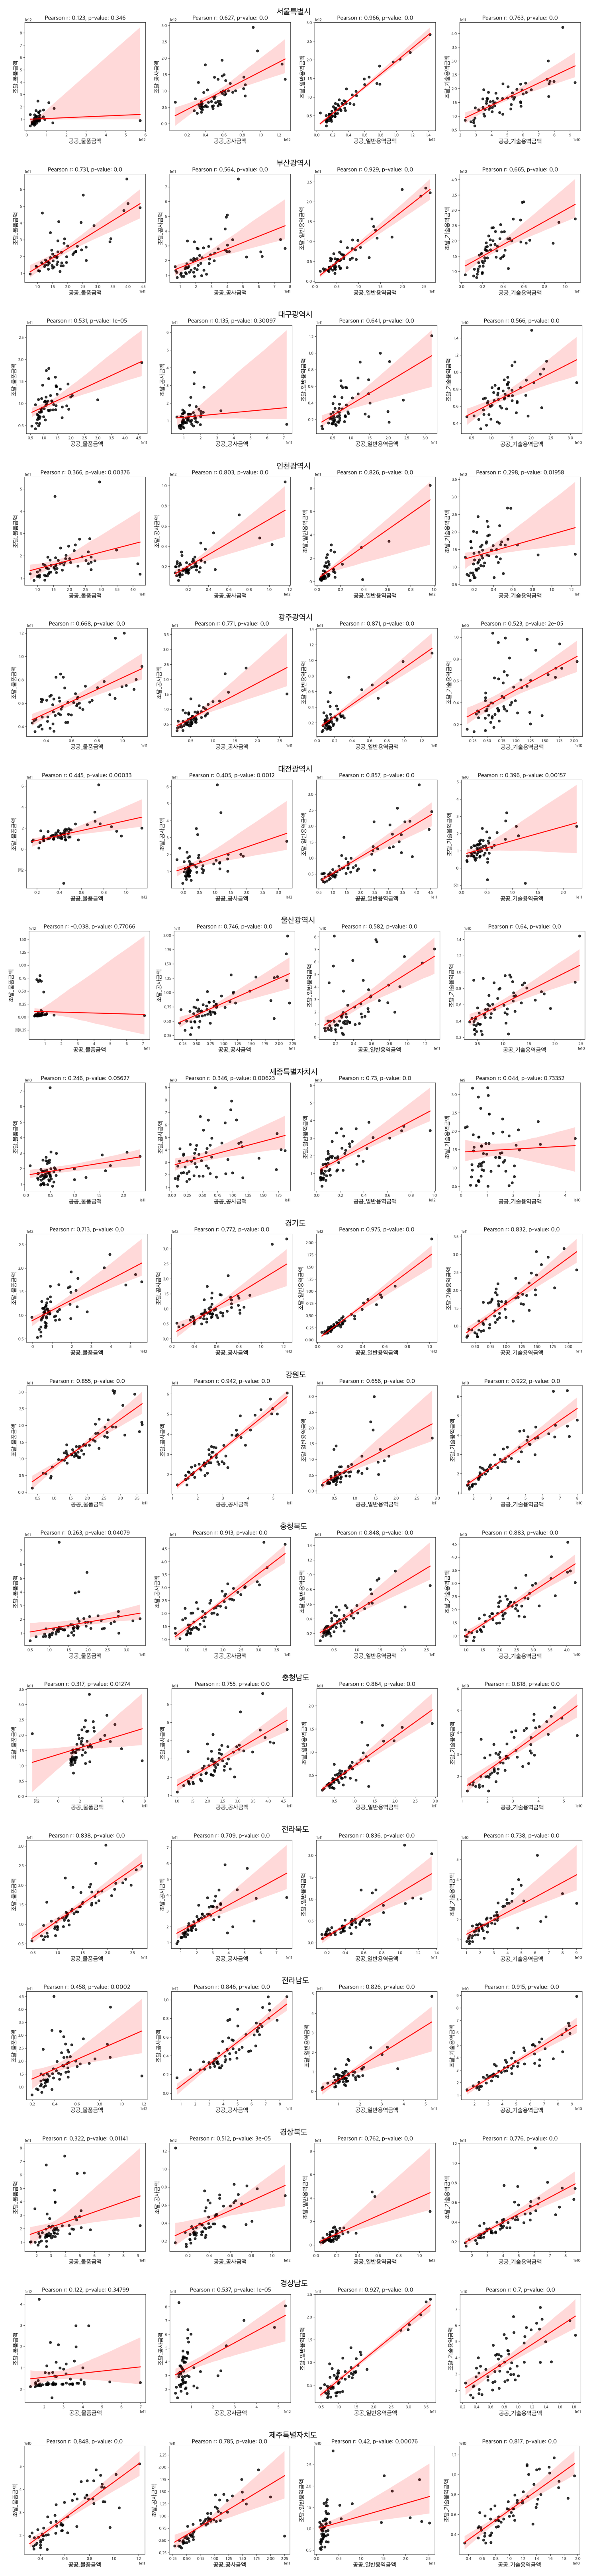

In [84]:
img_folder = '/Users/yungi/Documents/대학원졸업/조달청데이터분석공모'
images = [img for img in os.listdir(img_folder) if 'ScatterPearson_' in img and img.endswith(".png")]
images.sort(key=lambda x: int(x.split('.png')[0].split('_')[-1]))

fig, multi_ax = plt.subplots(nrows=17, ncols=1, figsize=(30,90))
for i, ax in enumerate(multi_ax.flat):
    img = cv2.imread(os.path.join(img_folder, images[i]))
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.axis('off')

plt.tight_layout()
# plt.savefig('ScatterPearsonCoeff_업무대상별_공공실적+조달실적_201611to202111.png', bbox_inches='tight', dpi=300)
plt.show()

# Performance Trending
## Stacked Bar Chart
### 지역업체전체실적 > 지역공공기관 지역수요 > 지역제한체결건 총금액 (2016.11~2021.11, 5years)

In [223]:
BasePath = '/Users/yungi/Documents/pps_dataset'
DataList = []
for y, m in month_year_iter(2016, 11, 2021, 12):
    # 지역별조달기업실적 Loading
    df1 = pd.read_excel(os.path.join(BasePath, '지역별조달기업소재지_실적_{}{:02d}.xlsx'.format(y, m)), header=[0,1], index_col=0)
    df1.columns = pd.Series(['조달_'+''.join(col) for col in df1.columns])
    df1 = df1.drop(['전체', '국외소재', '미분류']).reset_index().rename(columns={'index':'소재지'})
    df1 = df1[['소재지','조달_합계금액']]
    size = df1.shape[0]
    YM_df = pd.DataFrame({'YEAR':np.array([y]*size), 'MON':np.array([m]*size)})
    df1 = pd.concat([df1, YM_df], axis=1)
    
    # 지역공공기관 지역수요 Loading
    df2 = pd.read_csv(os.path.join(BasePath, '지역별지역업체실적비중_{}{:02d}.csv'.format(y, m)))
    df2 = df2[['소재지', '지역업체합계금액']].rename(columns={'지역업체합계금액':'공공기관지역수요'})

    # 지역제한체결건 총금액 Loading
    df3 = pd.read_excel(os.path.join(BasePath, '지역별지역제한실적비중_{}{:02d}.xlsx'.format(y, m)), header=[0,1], index_col=0)
    df3.columns = df3.columns.droplevel()
    df3 = pd.DataFrame(df3.drop(['전체']).reset_index()[['index', '(C)']].values, columns=['소재지', '지역제한총금액'])

    # Merge all together
    df1 = pd.merge(df1, df2, on='소재지', how='inner')
    df1 = pd.merge(df1, df3, on='소재지', how='inner')
    DataList.append(df1)

pf_dataset = pd.concat(DataList, axis=0, ignore_index=True)

/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [222]:
pf_dataset.head()

소재지       조달_합계금액  YEAR  MON      공공기관지역수요         지역제한총금액
0  서울특별시  2.138686e+12  2019   11  7.164110e+11  185117214299.0
1  부산광역시  5.984002e+11  2019   11  2.381561e+11   94179601768.0
2  대구광역시  2.830365e+11  2019   11  1.305895e+11   75442088365.0
3  인천광역시  3.924871e+11  2019   11  2.218892e+11   95523240560.0
4  광주광역시  1.681061e+11  2019   11  9.606698e+10   58712019583.0

In [241]:
for i, loc in tqdm(enumerate(pf_dataset['소재지'].unique())):
    fig, ax = plt.subplots(facecolor='w', figsize=(12,5))
    loc_target = pf_dataset[pf_dataset['소재지']==loc]
    xaxis = []
    yaxis = np.empty((0,3))
    for j, (y, m) in enumerate(month_year_iter(2016, 11, 2021, 12)):
        labels = [None, None, None]
        if j == 0:
            labels = ['지역제한금액', '공공기관지역수요', '지역업체총실적']
        ym_target = loc_target[(loc_target['YEAR']==y) & (loc_target['MON']==m)].reset_index(drop=True)
        x = ' / '.join([str(y),str(m)])
        xaxis.append(x)
        yaxis = np.append(yaxis, np.array([[ym_target['지역제한총금액'].values[0], ym_target['공공기관지역수요'].values[0], ym_target['조달_합계금액'].values[0]]]), axis=0)
        ax.bar(x, ym_target['조달_합계금액'], color='green', alpha=0.6, label=labels[2])
        ax.bar(x, ym_target['공공기관지역수요'], color='blue', alpha=0.6, label=labels[1])
        ax.bar(x, ym_target['지역제한총금액'], color='red', alpha=0.6, label=labels[0])
        
        for tick in ax.get_xticklabels():
            tick.set_rotation(70)
        
    plt.plot(xaxis, yaxis[:,0], color='red')
    plt.plot(xaxis, yaxis[:,1], color='blue')
    plt.plot(xaxis, yaxis[:,2], color='green')
    # fig.suptitle(loc, fontsize=15)
    plt.setp(ax.get_xticklabels(), fontsize=10)
    plt.tight_layout()
    plt.legend(prop={'size':12})
    plt.savefig("(NonTitle)StackedBarChart_지역총실적+공공기관지역수요_지역제한총액_{}_{}.png".format(loc, i), dpi=200, pad_inches=0.2, bbox_inches='tight')
    # plt.show()
    plt.close()

17it [00:26,  1.54s/it]


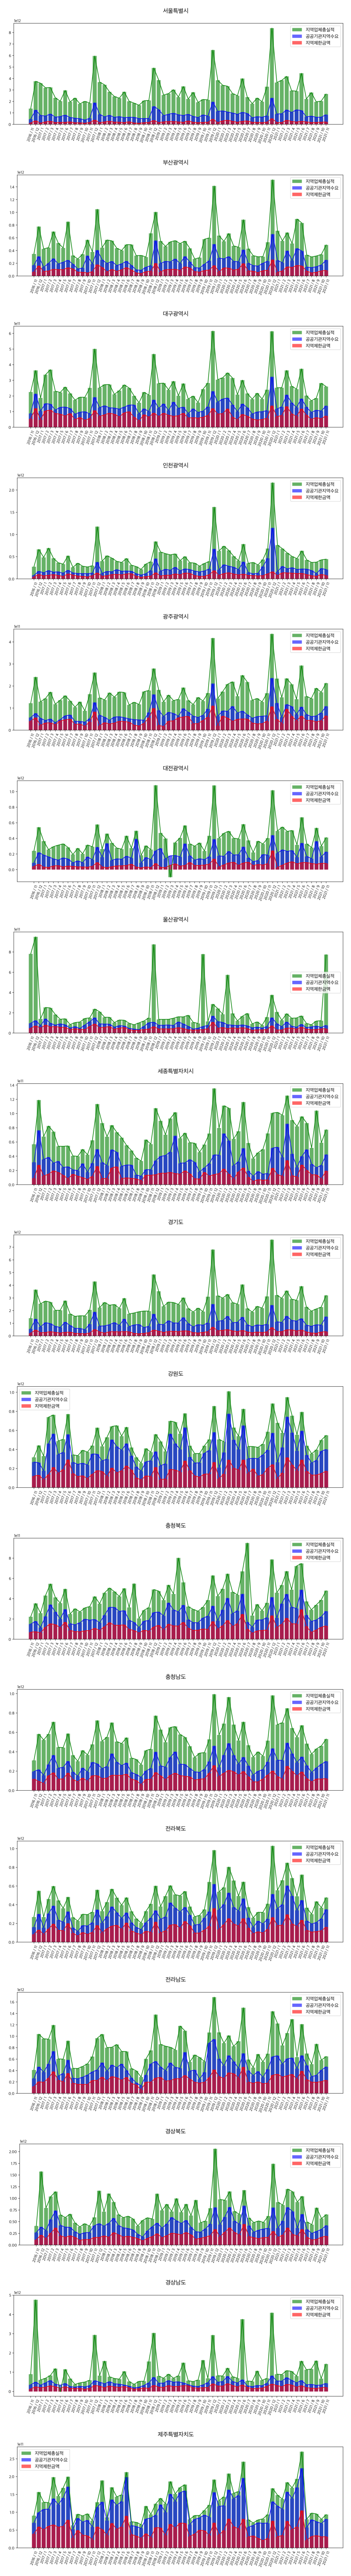

In [232]:
img_folder = '/Users/yungi/Documents/대학원졸업/조달청데이터분석공모'
images = [img for img in os.listdir(img_folder) if 'StackedBarChart_지역' in img and img.endswith(".png")]
images.sort(key=lambda x: int(x.split('.png')[0].split('_')[-1]))

fig, multi_ax = plt.subplots(nrows=17, ncols=1, figsize=(15,90))
for i, ax in enumerate(multi_ax.flat):
    img = cv2.imread(os.path.join(img_folder, images[i]))
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.axis('off')

plt.tight_layout()
# plt.savefig('StackedBarChart_ROK_지역총실적+공공기관지역수요+지역제한총액_201611to202111.png', bbox_inches='tight', dpi=200)
plt.show()

In [264]:
img_folder = '/Users/yungi/Documents/대학원졸업/조달청데이터분석공모'
Scatter_images = [img for img in os.listdir(img_folder) if 'ScatterPearson_' in img and img.endswith(".png")]
Scatter_images.sort(key=lambda x: int(x.split('.png')[0].split('_')[-1]))

SBC_images = [img for img in os.listdir(img_folder) if '(NonTitle)StackedBarChart_지역' in img and img.endswith(".png")]
SBC_images.sort(key=lambda x: int(x.split('.png')[0].split('_')[-1]))

for i, loc in tqdm(enumerate(pr_dataset.index)):
    fig, axs = plt.subplots(nrows=2, ncols=1, facecolor='w', figsize=(15,12))
    s_img = cv2.imread(os.path.join(img_folder, Scatter_images[i]))
    SBC_img = cv2.imread(os.path.join(img_folder, SBC_images[i]))
    axs[0].imshow(cv2.cvtColor(s_img, cv2.COLOR_BGR2RGB))
    axs[1].imshow(cv2.cvtColor(SBC_img, cv2.COLOR_BGR2RGB))
    axs[0].axis('off')
    axs[1].axis('off')
    fig.tight_layout(rect=[0, 0.03, 0.9, 0.85])
    #plt.savefig('PearsonScatter+StackedBarChart_{}_201611to202111.png'.format(loc), bbox_inches='tight', dpi=300)
    plt.close()

17it [00:37,  2.22s/it]


# Trend, Seasonal Factor Analysis (Time Series Analysis; TSA)
## 지역업체총실적 증가율 대비 지역제한실적비중 증가는 미비하다. 이 차이를 정량화(quantifying) 하기 위한 분석
### Time Series = Trend(추세) + Seasonality(계절성) + Residual(잔차)

In [310]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [293]:
pf_dataset

소재지       조달_합계금액  YEAR  MON      공공기관지역수요         지역제한총금액
0       서울특별시  1.373590e+12  2016   11  4.474468e+11    124364709067
1       부산광역시  3.474342e+11  2016   11  1.701145e+11     64709799358
2       대구광역시  2.252989e+11  2016   11  8.761751e+10     54406245106
3       인천광역시  2.739497e+11  2016   11  7.995805e+10     45899662981
4       광주광역시  1.223786e+11  2016   11  5.702454e+10     41011628946
...       ...           ...   ...  ...           ...             ...
1032     전라북도  4.764850e+11  2021   11  3.496019e+11  160810739532.0
1033     전라남도  6.461408e+11  2021   11  4.653080e+11  230511768771.0
1034     경상북도  6.530881e+11  2021   11  4.170601e+11  190558340030.0
1035     경상남도  1.428728e+12  2021   11  4.183349e+11  217171518499.0
1036  제주특별자치도  9.361058e+10  2021   11  8.064946e+10   31536402610.0

[1037 rows x 6 columns]

In [307]:
target = pf_dataset[pf_dataset['소재지']=='서울특별시']
target.index = pd.Index(target[['YEAR', 'MON']].agg(lambda x: '{}-{:02d}'.format(x[0], x[1]), axis=1))
target

소재지       조달_합계금액  YEAR  MON      공공기관지역수요         지역제한총금액
2016-11  서울특별시  1.373590e+12  2016   11  4.474468e+11    124364709067
2016-12  서울특별시  3.755025e+12  2016   12  1.244717e+12    311296540470
2017-01  서울특별시  3.587097e+12  2017    1  7.762501e+11    103784028993
2017-02  서울특별시  3.189573e+12  2017    2  7.226123e+11    221421563384
2017-03  서울특별시  3.216147e+12  2017    3  9.033655e+11    265519986017
...        ...           ...   ...  ...           ...             ...
2021-07  서울특별시  2.214204e+12  2021    7  6.543871e+11  218064807390.0
2021-08  서울특별시  2.778316e+12  2021    8  7.194419e+11  160105715559.0
2021-09  서울특별시  1.966944e+12  2021    9  6.167125e+11  170851117834.0
2021-10  서울특별시  2.026868e+12  2021   10  6.250060e+11  183050623878.0
2021-11  서울특별시  2.647580e+12  2021   11  8.360352e+11  208810024365.0

[61 rows x 6 columns]

/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


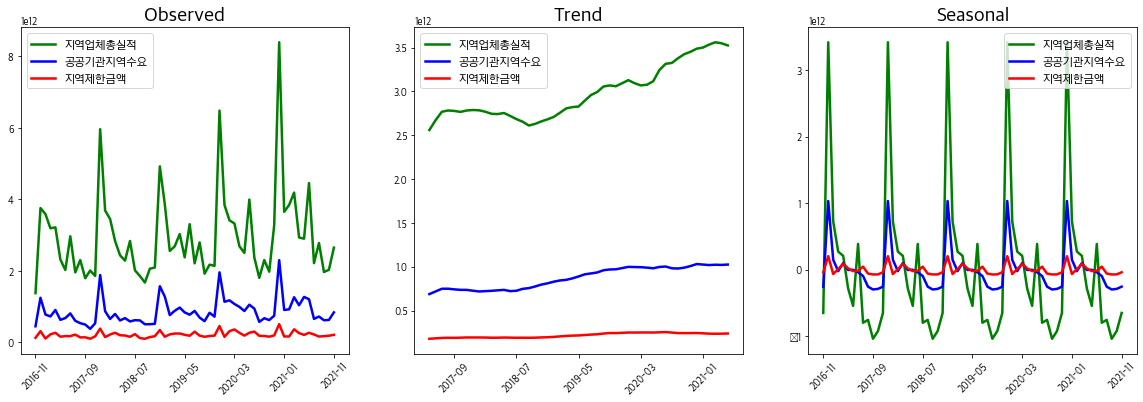

In [351]:
fig, axs = plt.subplots(nrows=1, ncols=3, facecolor='w', figsize=(20,6))
total_tsa = seasonal_decompose(target['조달_합계금액'], model='additive', period=12)
govern_tsa = seasonal_decompose(target['공공기관지역수요'], model='additive', period=12)
limited_tsa = seasonal_decompose(target['지역제한총금액'], model='additive', period=12)

axs[0].set_title("Observed", fontsize=20)
total_tsa.observed.plot(ax=axs[0], color='green', linewidth=2.5, label='지역업체총실적')
govern_tsa.observed.plot(ax=axs[0], color='blue', linewidth=2.5, label='공공기관지역수요')
limited_tsa.observed.plot(ax=axs[0], color='red', linewidth=2.5, label='지역제한금액')
axs[0].legend(prop={'size':12})

axs[1].set_title("Trend", fontsize=20)
total_tsa.trend.plot(ax=axs[1], color='green', linewidth=2.5, label='지역업체총실적')
govern_tsa.trend.plot(ax=axs[1], color='blue', linewidth=2.5, label='공공기관지역수요')
limited_tsa.trend.plot(ax=axs[1], color='red', linewidth=2.5, label='지역제한금액')
axs[1].legend(prop={'size':12})

axs[2].set_title("Seasonal", fontsize=20)
total_tsa.seasonal.plot(ax=axs[2], color='green', linewidth=2.5, label='지역업체총실적')
govern_tsa.seasonal.plot(ax=axs[2], color='blue', linewidth=2.5, label='공공기관지역수요')
limited_tsa.seasonal.plot(ax=axs[2], color='red', linewidth=2.5, label='지역제한금액')
axs[2].legend(prop={'size':12})

for ax in axs.flat:
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

plt.show()

In [357]:
for i, loc in tqdm(enumerate(pf_dataset['소재지'].unique())):
    target = pf_dataset[pf_dataset['소재지']==loc]
    target.index = pd.Index(target[['YEAR', 'MON']].agg(lambda x: '{}-{:02d}'.format(x[0], x[1]), axis=1))

    fig, axs = plt.subplots(nrows=1, ncols=3, facecolor='w', figsize=(20,6))
    total_tsa = seasonal_decompose(target['조달_합계금액'], model='additive', period=12)
    govern_tsa = seasonal_decompose(target['공공기관지역수요'], model='additive', period=12)
    limited_tsa = seasonal_decompose(target['지역제한총금액'], model='additive', period=12)

    axs[0].set_title("Observed", fontsize=20)
    total_tsa.observed.plot(ax=axs[0], color='green', linewidth=2.5, label='지역업체총실적')
    govern_tsa.observed.plot(ax=axs[0], color='blue', linewidth=2.5, label='공공기관지역수요')
    limited_tsa.observed.plot(ax=axs[0], color='red', linewidth=2.5, label='지역제한금액')
    axs[0].legend(prop={'size':12})

    axs[1].set_title("Trend", fontsize=20)
    total_tsa.trend.plot(ax=axs[1], color='green', linewidth=2.5, label='지역업체총실적')
    govern_tsa.trend.plot(ax=axs[1], color='blue', linewidth=2.5, label='공공기관지역수요')
    limited_tsa.trend.plot(ax=axs[1], color='red', linewidth=2.5, label='지역제한금액')
    axs[1].legend(loc='upper left', prop={'size':12})

    axs[2].set_title("Seasonal", fontsize=20)
    total_tsa.seasonal.plot(ax=axs[2], color='green', linewidth=2.5, label='지역업체총실적')
    govern_tsa.seasonal.plot(ax=axs[2], color='blue', linewidth=2.5, label='공공기관지역수요')
    limited_tsa.seasonal.plot(ax=axs[2], color='red', linewidth=2.5, label='지역제한금액')
    axs[2].legend(loc='upper right', prop={'size':12})

    for ax in axs.flat:
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)

    fig.suptitle("< " + loc + " >", fontsize=25)
    plt.tight_layout()
    plt.savefig("TSA_Trend+Seasonal_지역업체총실적+지역수요+지역제한금액_{}_{}.png".format(loc, i), dpi=300, pad_inches=0.2, bbox_inches='tight')
    plt.close()

0it [00:00, ?it/s]ipykernel_launcher:33: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
ipykernel_launcher:34: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
1it [00:01,  1.18s/it]ipykernel_launcher:33: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
ipykernel_launcher:34: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
2it [00:02,  1.18s/it]ipykernel_launcher:33: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
ipykernel_launcher:34: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
3it [00:03,  1.11s/it]ipykernel_launcher:33: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
ipykernel_launcher:34: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
4it [00:04,  1.11s/it]ipykernel_launcher:33: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
ipykernel_launcher:34: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing fro

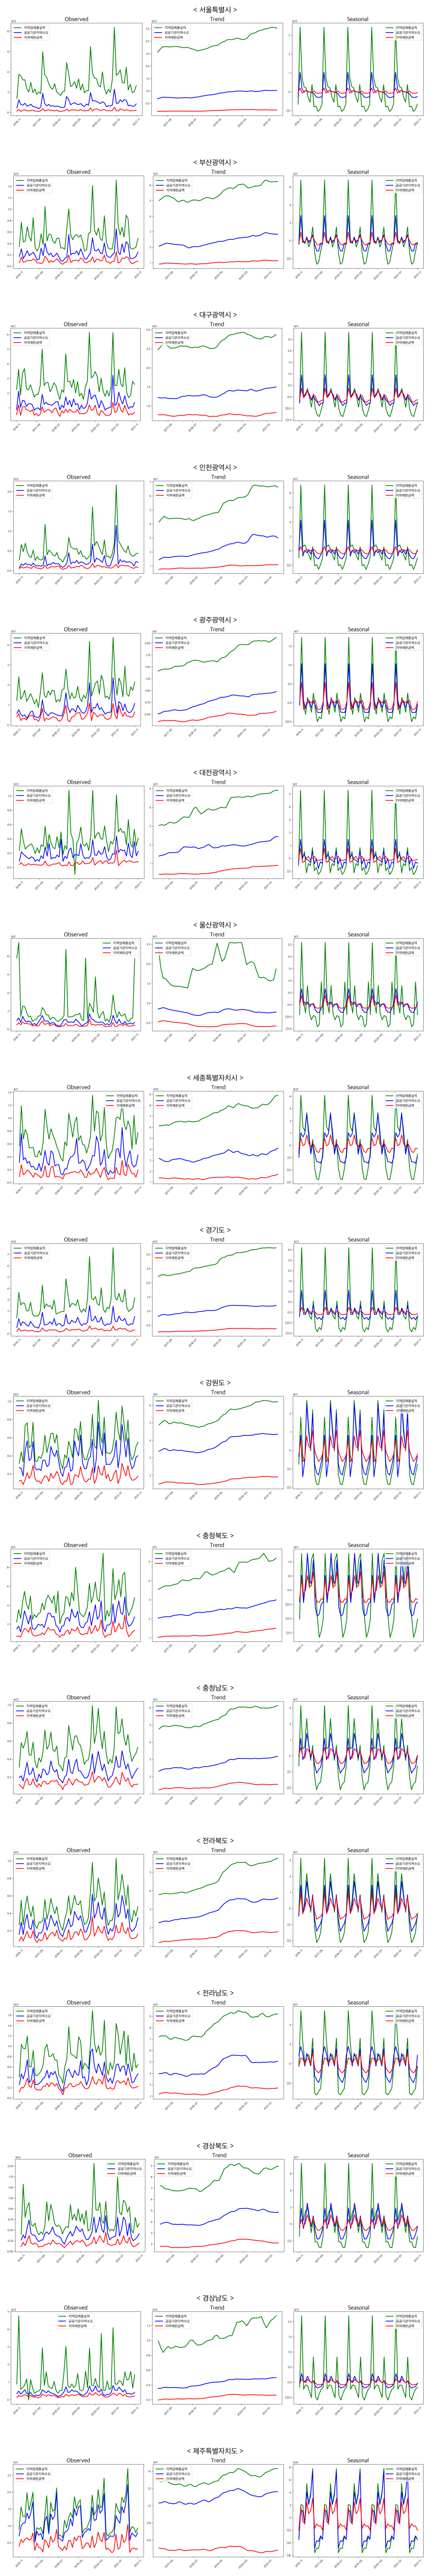

In [359]:
img_folder = '/Users/yungi/Documents/대학원졸업/조달청데이터분석공모'
images = [img for img in os.listdir(img_folder) if 'TSA_' in img and img.endswith(".png")]
images.sort(key=lambda x: int(x.split('.png')[0].split('_')[-1]))

fig, multi_ax = plt.subplots(nrows=17, ncols=1, figsize=(15,90))
for i, ax in enumerate(multi_ax.flat):
    img = cv2.imread(os.path.join(img_folder, images[i]))
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.axis('off')

plt.tight_layout()
plt.savefig('TSA_ROK_Trend+Seasonal_지역업체총실적+지역수요+지역제한금액_201611to202111.png', pad_inches=0.2, bbox_inches='tight', dpi=200)
plt.show()

# Spatial Distribution of all Korean Companies (for SMEs; Small and Medium-sized Enterprises)

In [6]:
BasePath = '/Users/yungi/Documents/pps_dataset/CTPRVN_202101'
FileName = 'TL_SCCO_CTPRVN.shp'
RoK = gpd.read_file(os.path.join(BasePath, FileName), encoding='euc-kr')
RoK

CTPRVN_CD         CTP_ENG_NM CTP_KOR_NM  \
0         42         Gangwon-do        강원도   
1         41        Gyeonggi-do        경기도   
2         48   Gyeongsangnam-do       경상남도   
3         47   Gyeongsangbuk-do       경상북도   
4         29            Gwangju      광주광역시   
5         27              Daegu      대구광역시   
6         30            Daejeon      대전광역시   
7         26              Busan      부산광역시   
8         11              Seoul      서울특별시   
9         36          Sejong-si    세종특별자치시   
10        31              Ulsan      울산광역시   
11        28            Incheon      인천광역시   
12        46        Jellanam-do       전라남도   
13        45       Jeollabuk-do       전라북도   
14        50            Jeju-do    제주특별자치도   
15        44  Chungcheongnam-do       충청남도   
16        43  Chungcheongbuk-do       충청북도   

                                             geometry  
0   MULTIPOLYGON (((1163759.191 1909653.101, 11637...  
1   MULTIPOLYGON (((931607.470 1894480.382, 931653...  
2   MULTIPOLYGON (((1053643.218 1612344.022, 10536...  
3   MULTIPOLYGON (((1171290.353 1782200.848, 11712...  
4   POLYGON ((932712.687 1696168.692, 932781.680 1...  
5   POLYGON ((1107777.593 1780522.269, 1107845.409...  
6   POLYGON ((990946.725 1832389.260, 991057.692 1...  
7   MULTIPOLYGON (((1137080.579 1677826.696, 11370...  
8   POLYGON ((966987.226 1941110.946, 966987.119 1...  
9   POLYGON ((971235.936 1844386.985, 971234.055 1...  
10  MULTIPOLYGON (((1167949.952 1710285.043, 11679...  
11  MULTIPOLYGON (((897904.035 1961082.190, 897886...  
12  MULTIPOLYGON (((946598.396 1555245.584, 946595...  
13  MULTIPOLYGON (((902676.539 1717491.597, 902679...  
14  MULTIPOLYGON (((885004.560 1458756.461, 884996...  
15  MULTIPOLYGON (((862386.074 1805282.887, 862296...  
16  POLYGON ((1042689.435 1917662.690, 1042731.339...

In [14]:
# 2019년 기준 중소기업 업체 수(만개) 지역 현황 (중소벤처기업부 홈페이지 통계자료 참고)
NumComDF = pd.DataFrame({'중소기업수':np.array([147.4, 44.1, 30.9, 35.4, 18.1, 17.8, 12.8, 3.5, 170.5, 21.1, 20.5, 27.7, 24.8, 25.6, 34.7, 42.8, 11.1]), 'CTP_KOR_NM':np.array(['서울특별시', '부산광역시', '대구광역시', '인천광역시', '광주광역시', '대전광역시', '울산광역시', '세종특별자치시', '경기도', '강원도', '충청북도', '충청남도', '전라북도', '전라남도', '경상북도', '경상남도', '제주특별자치도'])})
RoK = pd.merge(RoK, NumComDF, on='CTP_KOR_NM', how='inner')

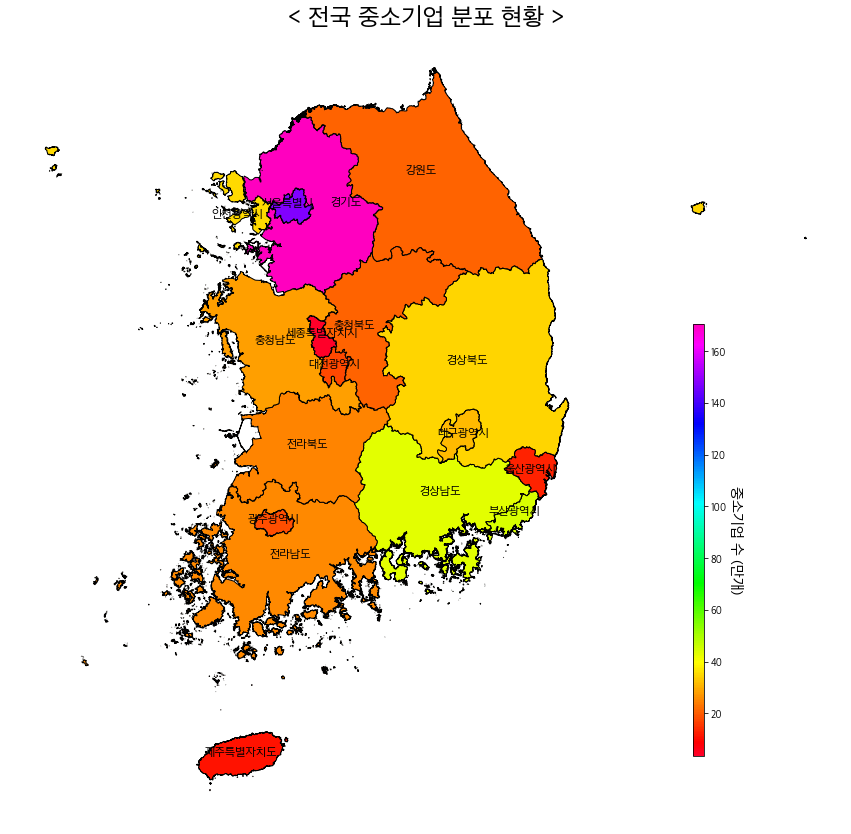

In [69]:
RoK['text_coords'] = RoK['geometry'].apply(lambda x: x.representative_point().coords[:])
RoK['text_coords'] = [coords[0] for coords in RoK['text_coords']]

vmin = RoK['중소기업수'].min()
vmax = RoK['중소기업수'].max()
cmap = 'gist_rainbow'

fig, ax = plt.subplots(facecolor='w', figsize=(15,15))
RoK.plot(column='중소기업수', ax=ax, edgecolor='0', linewidth=1, cmap=cmap)
ax.set_title('< 전국 중소기업 분포 현황 >', fontdict={'fontsize': 25, 'fontweight': 10})
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)
cbaxes = fig.add_axes([0.76, 0.2, 0.01, 0.4])
cbar = fig.colorbar(sm, cax=cbaxes)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('중소기업 수 (만개)', rotation=270, fontsize=15)
ax.axis('off')
for _, row in RoK.iterrows():
    ax.annotate(row['CTP_KOR_NM'], xy=row['text_coords'], horizontalalignment='center', weight='bold', fontsize=12)

# plt.savefig("SpatialDist_SMEs_전국중소기업수분포_2019년기준.png", dpi=300, pad_inches=0.2, bbox_inches='tight')
plt.show()

# 중소기업 사업체 증감 추이

In [71]:
BasePath = "/Users/yungi/Documents/pps_dataset/"
smes = pd.read_excel(os.path.join(BasePath, "시도별_중소기업사업체수.xlsx"), header=1, index_col=0)
smes

/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


산업별(10차)대분류         전체       중소기업       전체.1  \
지역별                                                                      
전국                                전산업  5893802.0  5889611.0  6085434.0   
NaN             A. 농업, 임업 및 어업(01~03)    72114.0    72103.0    75811.0   
NaN                      B. 광업(05~08)          X     2648.0          X   
NaN                     C. 제조업(10~34)   520181.0   518673.0   528137.0   
NaN      D. 전기, 가스, 증기 및 공기조절 공급업(35)    20601.0    20517.0    24848.0   
..                                ...        ...        ...        ...   
NaN  N. 사업시설관리, 사업지원 및 임대 서비스업(74~76)     1754.0     1754.0     1867.0   
NaN                    P. 교육 서비스업(85)          X     2369.0          X   
NaN         Q. 보건업 및 사회복지 서비스업(86~87)      841.0      841.0      889.0   
NaN     R. 예술, 스포츠 및 여가관련 서비스업(90~91)     1787.0     1781.0     1955.0   
NaN         S. 수리 및 기타 개인 서비스업(94~96)     4622.0     4622.0     4878.0   

        중소기업.1       전체.2     중소기업.2       전체.3     중소기업.3       전체.4  \
지역별                                                                     
전국   6080914.0  6301013.0  6296210.0  6643756.0  6638694.0  6893706.0   
NaN    75791.0    79778.0    79756.0    83212.0    83192.0    88476.0   
NaN     2621.0          X     2587.0          X     2675.0          X   
NaN   526566.0   557288.0   555679.0   569468.0   567815.0   579002.0   
NaN    24766.0    45231.0    45129.0    74912.0    74807.0    94307.0   
..         ...        ...        ...        ...        ...        ...   
NaN     1867.0     2591.0     2581.0          X     2847.0          X   
NaN     2504.0          X     2630.0          X     2831.0          X   
NaN      889.0      938.0      938.0      970.0      970.0     1031.0   
NaN     1950.0     2115.0     2110.0     2319.0     2312.0     2432.0   
NaN     4878.0     4753.0     4753.0     4942.0     4942.0     5452.0   

        중소기업.4  
지역별             
전국   6888435.0  
NaN    88457.0  
NaN     2654.0  
NaN   577345.0  
NaN    94195.0  
..         ...  
NaN     3061.0  
NaN     3173.0  
NaN     1031.0  
NaN     2425.0  
NaN     5452.0  

[342 rows x 11 columns]

In [72]:
smes = smes[smes.index.notnull()]
smes = smes.loc[:, [True if '중소기업' in col else False for col in smes.columns]]
smes

중소기업     중소기업.1     중소기업.2     중소기업.3     중소기업.4
지역별                                                       
전국   5889611.0  6080914.0  6296210.0  6638694.0  6888435.0
서울   1320900.0  1343319.0  1368812.0  1434046.0  1474464.0
부산    398973.0   408218.0   417650.0   431202.0   440750.0
대구    280126.0   287527.0   294000.0   303688.0   309276.0
인천    299636.0   310836.0   321692.0   340157.0   353767.0
광주    157518.0   161758.0   166221.0   175214.0   181228.0
대전    159370.0   162745.0   166378.0   172532.0   178256.0
울산    115017.0   118723.0   121489.0   125352.0   127682.0
세종     19443.0    23227.0    26911.0    31067.0    34608.0
경기   1364733.0  1430018.0  1501547.0  1614255.0  1705431.0
강원    182222.0   188182.0   194930.0   203550.0   210955.0
충북    175502.0   180766.0   187373.0   196723.0   204934.0
충남    231685.0   240068.0   251709.0   266341.0   276774.0
전북    203994.0   209831.0   221470.0   238368.0   247954.0
전남    214685.0   221526.0   232506.0   246941.0   256443.0
경북    304486.0   312530.0   323295.0   336908.0   347313.0
경남    378072.0   390992.0   402593.0   417331.0   427617.0
제주     83249.0    90648.0    97634.0   105019.0   110983.0

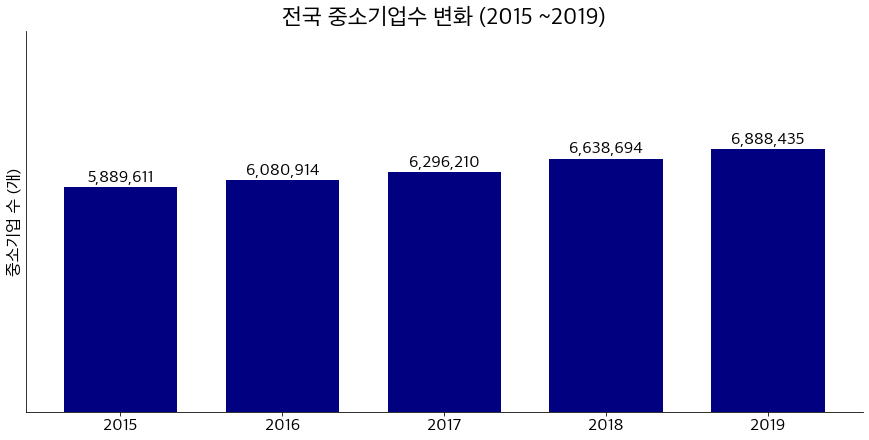

In [125]:
years = [2015, 2016, 2017, 2018, 2019]
fig, ax = plt.subplots(facecolor='w', figsize=(15,7))
total_count = smes.loc['전국', ].values
bar_chart = ax.bar(years, total_count, width=0.7, color='navy')
for bc in bar_chart:
    height = bc.get_height()
    ax.text(bc.get_x() + bc.get_width()/2., 1.01*height, '{:,}'.format(int(height)), ha='center', va='bottom', fontsize=17)

ax.margins(0.05, 0.45)
ax.tick_params(labelsize=17, left=False, labelleft=False)
ax.set_ylabel("중소기업 수 (개)", fontsize=17)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title("전국 중소기업수 변화 (2015 ~2019)", fontsize=23)
# plt.savefig("전국_중소기업수_변화_2015to2019.png", dpi=200, pad_inches=0.2, bbox_inches='tight')
plt.show()